In [2]:
import pandas as pd
import numpy as np
import torch
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from sklearn.ensemble import IsolationForest
from tqdm.auto import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class CustomDataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.df = pd.read_csv(file_path)
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        img_path = './datas/' + self.df['img_path'].iloc[idx]
        image = Image.open(img_path)
        image = self.transform(image) if self.transform else image
        return image
        

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = CustomDataset(file_path='./datas/train.csv', transform=transform)
train_loader = DataLoader(train_data, batch_size=32, shuffle=False)

In [4]:
model = models.resnet50(pretrained=True).to(device)
model.eval()

model = torch.nn.Sequential(*list(model.children())[:-1])

def get_embeddings(dataloader, model):
    embeddings = []
    with torch.no_grad():
        for images in tqdm(dataloader):
            images = images.to(device)
            emb = model(images)
            embeddings.append(emb.cpu().numpy().squeeze())
    return np.concatenate(embeddings, axis=0)

train_embeddings = get_embeddings(train_loader, model)

g:\내 드라이브\DACON\DACON-Semiconductor-device-abnormality-detection-AI\anomaly\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
g:\내 드라이브\DACON\DACON-Semiconductor-device-abnormality-detection-AI\anomaly\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
clf = IsolationForest(random_state=42)
clf.fit(train_embeddings)

IsolationForest(random_state=42)

In [12]:
test_data = CustomDataset(file_path = './datas/test.csv', transform=transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

test_embeddings = get_embeddings(test_loader, model)
test_pred = clf.predict(test_embeddings)

test_pred = np.where(test_pred == -1, 1, 0)

  0%|          | 0/4 [00:00<?, ?it/s]

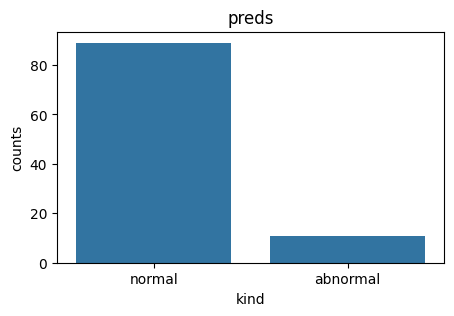

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# test_pred의 값 분포를 확인하는 바 차트
plt.figure(figsize=(5, 3))
sns.countplot(x=test_pred)
plt.title('preds')
plt.xlabel('kind')
plt.ylabel('counts')
plt.xticks(ticks=[0, 1], labels=['normal', 'abnormal'])
plt.show()

In [29]:
submit = pd.read_csv('./datas/sample_submission.csv')
submit['label'] = test_pred
submit.head()

submit.to_csv('./submits/baseline_submit.csv', index=False)